### Import libraries and data

In [4]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [5]:
df = pd.read_csv('data/unique_outages.csv', parse_dates=['Start', 'Finish', 'file_name'])

# removed unplanned
df = df[df['Unplanned?'] != 1]
# filter the duration hours, only if there are expected outages, and non-outlier values, remove the one 'VIC/ TAS'
df = df[(df['Duration_Hours'] <= 1000) &(df['Duration_Hours'] != 0) & (df['Region'] != 'VIC/ TAS')]

### Create bins for the output for classification 

### Random forest classification

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
)
import matplotlib.gridspec as gridspec

def train_and_evaluate_rf(df, train_model=True, model=None, test_size=0.2, random_state=42):

    # --- 0. Bin Duration_Hours into 6 quantile-based bins (region-specific)
    df = df.copy()
    try:
        df['Duration_Category'] = pd.qcut(df['Duration_Hours'], q=6, duplicates='drop')
    except ValueError:
        print("Not enough unique values to create 6 bins; reducing to available unique bins.")
        df['Duration_Category'] = pd.qcut(df['Duration_Hours'], q=len(df['Duration_Hours'].unique()), duplicates='drop')

    # Convert to string labels for readability
    df['Duration_Category'] = df['Duration_Category'].astype(str)

    # --- 1. Select Features and Target
    features = ['Recall_Day_Hours', 'Recall_Night_Hours',
                'Project Work?', 'DNSP Aware?', 'Generator Aware?', 'Inter-Regional',
                'Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description']
    target = 'Duration_Category'

    X = df[features].copy()
    y = df[target]

    # --- 2. Encode Categorical Features
    for col in ['Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description']:
        X[col] = LabelEncoder().fit_transform(X[col])

    # --- 3. Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # --- 4. Train Model
    if train_model or model is None:
        model = RandomForestClassifier(random_state=random_state, class_weight='balanced')
        model.fit(X_train, y_train)

    # --- 5. Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # --- 6. Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # --- 7. Labels
    present_labels = sorted(y.unique())

    # --- 8. Classification Report
    print("Classification Report (Test Set):")
    print(classification_report(y_test, y_test_pred, labels=present_labels, zero_division=0))

    # --- 9. Plots
    fig = plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

    # --- Feature Importances
    ax0 = fig.add_subplot(gs[0, :])
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = X.columns

    ax0.barh(np.array(feature_names)[indices], importances[indices], color='goldenrod')
    ax0.invert_yaxis()
    ax0.set_title("Feature Importances")
    ax0.set_xlabel("Importance")

    # --- Confusion Matrices
    cm_train = confusion_matrix(y_train, y_train_pred, labels=present_labels)
    cm_test = confusion_matrix(y_test, y_test_pred, labels=present_labels)

    ax1 = fig.add_subplot(gs[1, 0])
    disp_train = ConfusionMatrixDisplay(cm_train, display_labels=present_labels)
    disp_train.plot(ax=ax1, cmap='viridis', xticks_rotation=45, values_format='d', colorbar=False)
    ax1.set_title(f"Train Confusion Matrix\n(Acc: {train_acc:.2%})")

    ax2 = fig.add_subplot(gs[1, 1])
    disp_test = ConfusionMatrixDisplay(cm_test, display_labels=present_labels)
    disp_test.plot(ax=ax2, cmap='viridis', xticks_rotation=45, values_format='d', colorbar=False)
    ax2.set_title(f"Test Confusion Matrix\n(Acc: {test_acc:.2%})")

    # --- Duration Category Distributions
    train_categories = y_train.value_counts().sort_index()
    test_categories = y_test.value_counts().sort_index()

    train_counts = train_categories.reindex([label for label in present_labels if label in train_categories.index])
    test_counts = test_categories.reindex([label for label in present_labels if label in test_categories.index])

    ax3 = fig.add_subplot(gs[2, 0])
    ax3.bar(train_counts.index, train_counts.values, color='darkcyan')
    ax3.set_title("Train Set Duration Category Distribution")
    ax3.set_xlabel("Duration Category")
    ax3.set_ylabel("Count")
    ax3.tick_params(axis='x', rotation=45)

    ax4 = fig.add_subplot(gs[2, 1])
    ax4.bar(test_counts.index, test_counts.values, color='slateblue')
    ax4.set_title("Test Set Duration Category Distribution")
    ax4.set_xlabel("Duration Category")
    ax4.set_ylabel("Count")
    ax4.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return model


--- Region: SA ---
Classification Report (Test Set):
                precision    recall  f1-score   support

  (0.169, 7.6]       0.60      0.46      0.52        13
(153.6, 561.6]       0.38      0.75      0.50         4
  (33.6, 81.6]       0.31      0.56      0.40         9
   (7.6, 33.6]       0.46      0.50      0.48        12
 (81.6, 153.6]       1.00      0.55      0.71        20

      accuracy                           0.53        58
     macro avg       0.55      0.56      0.52        58
  weighted avg       0.65      0.53      0.56        58



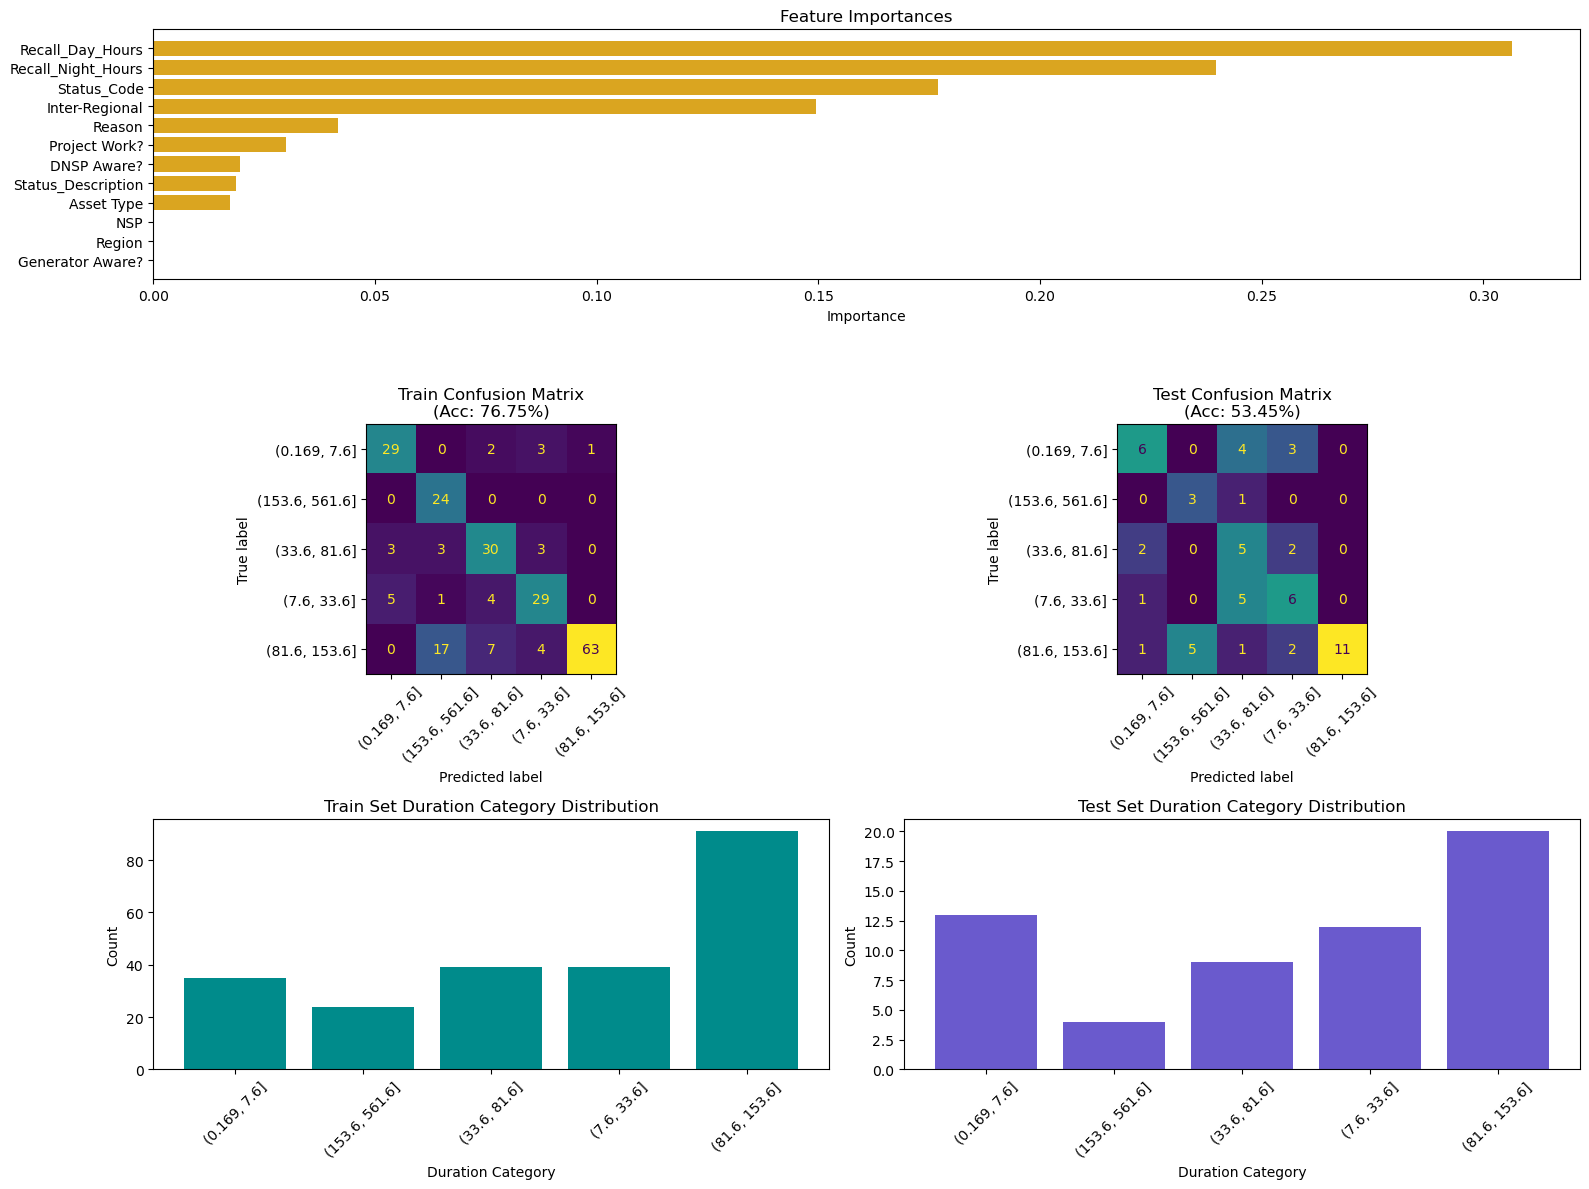

--- Region: VIC ---
Classification Report (Test Set):
               precision    recall  f1-score   support

(0.499, 10.0]       0.71      0.43      0.54        98
 (10.0, 11.0]       0.38      0.54      0.45        24
 (11.0, 12.0]       0.82      0.62      0.71        90
 (12.0, 12.5]       0.11      0.88      0.19         8
(12.5, 753.6]       0.58      0.45      0.51        31

     accuracy                           0.53       251
    macro avg       0.52      0.58      0.48       251
 weighted avg       0.69      0.53      0.57       251



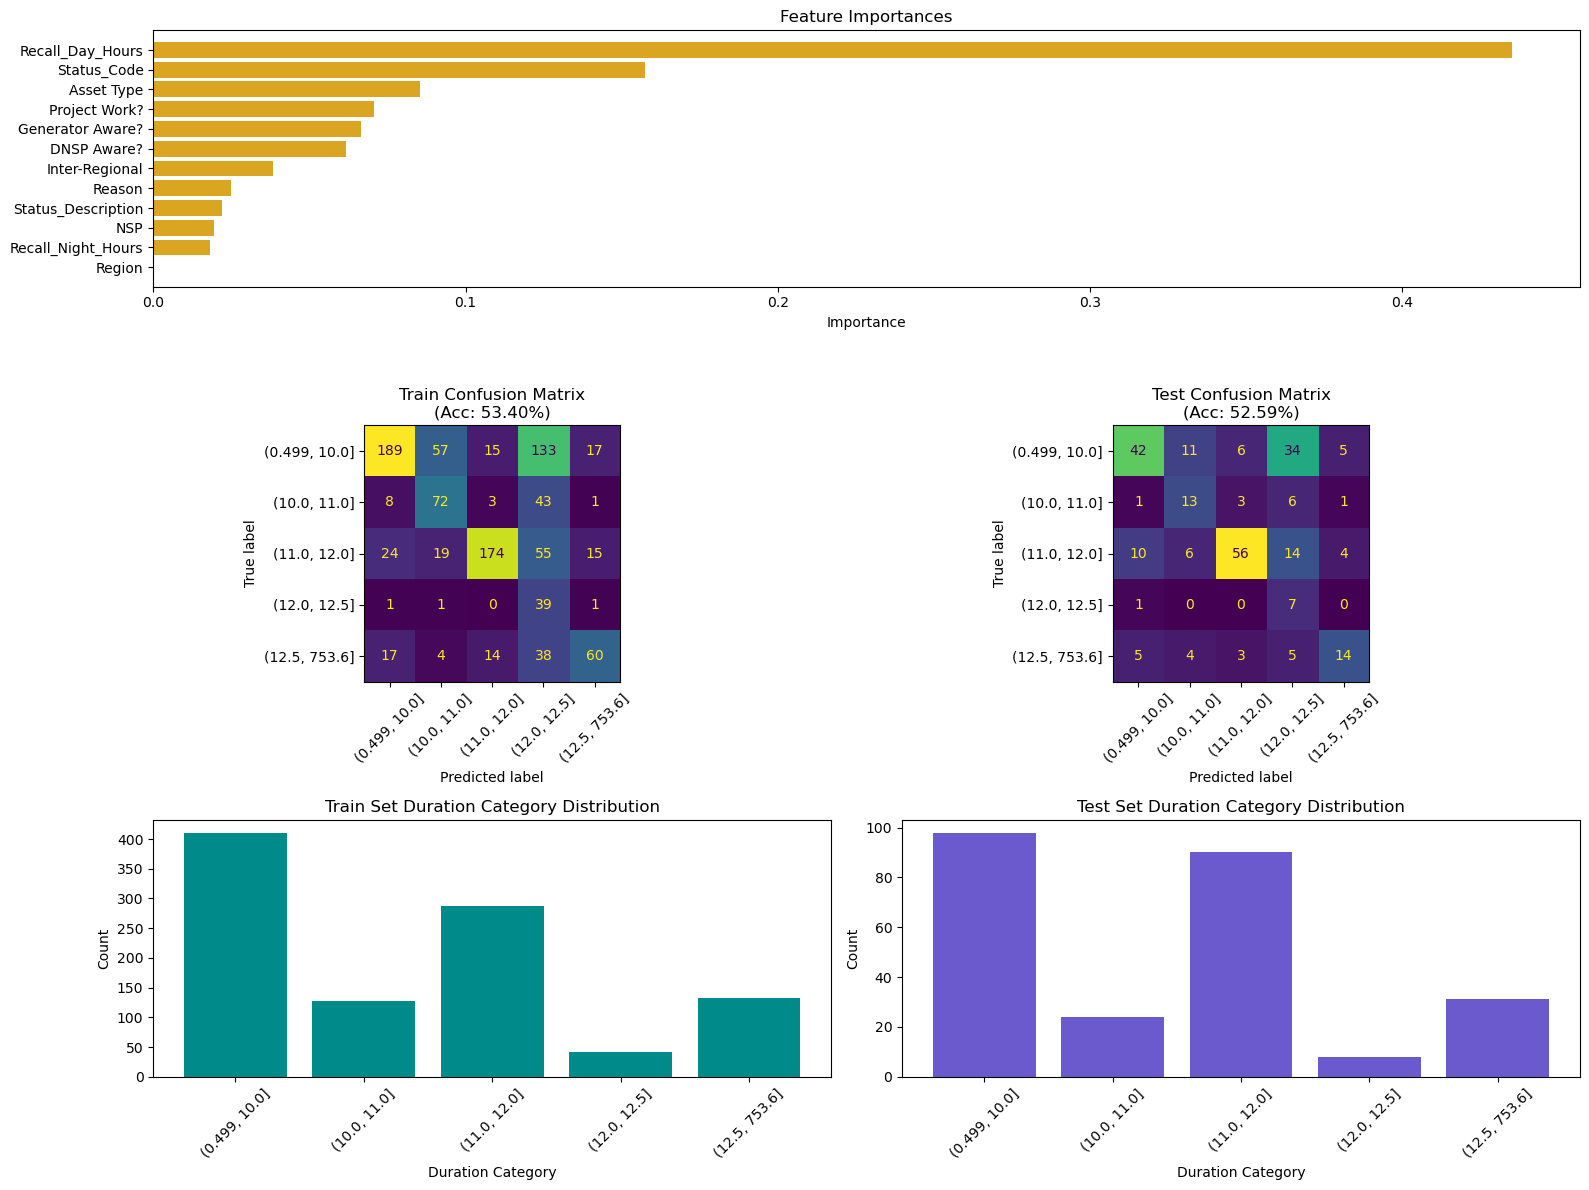

--- Region: TAS ---
Classification Report (Test Set):
               precision    recall  f1-score   support

 (0.999, 2.5]       0.71      1.00      0.83         5
   (2.5, 6.5]       0.00      0.00      0.00         4
   (6.5, 8.0]       0.57      0.57      0.57         7
(79.2, 513.6]       1.00      0.25      0.40         4
   (8.0, 8.5]       0.00      0.00      0.00         1
  (8.5, 79.2]       0.78      0.88      0.82         8

     accuracy                           0.59        29
    macro avg       0.51      0.45      0.44        29
 weighted avg       0.61      0.59      0.56        29



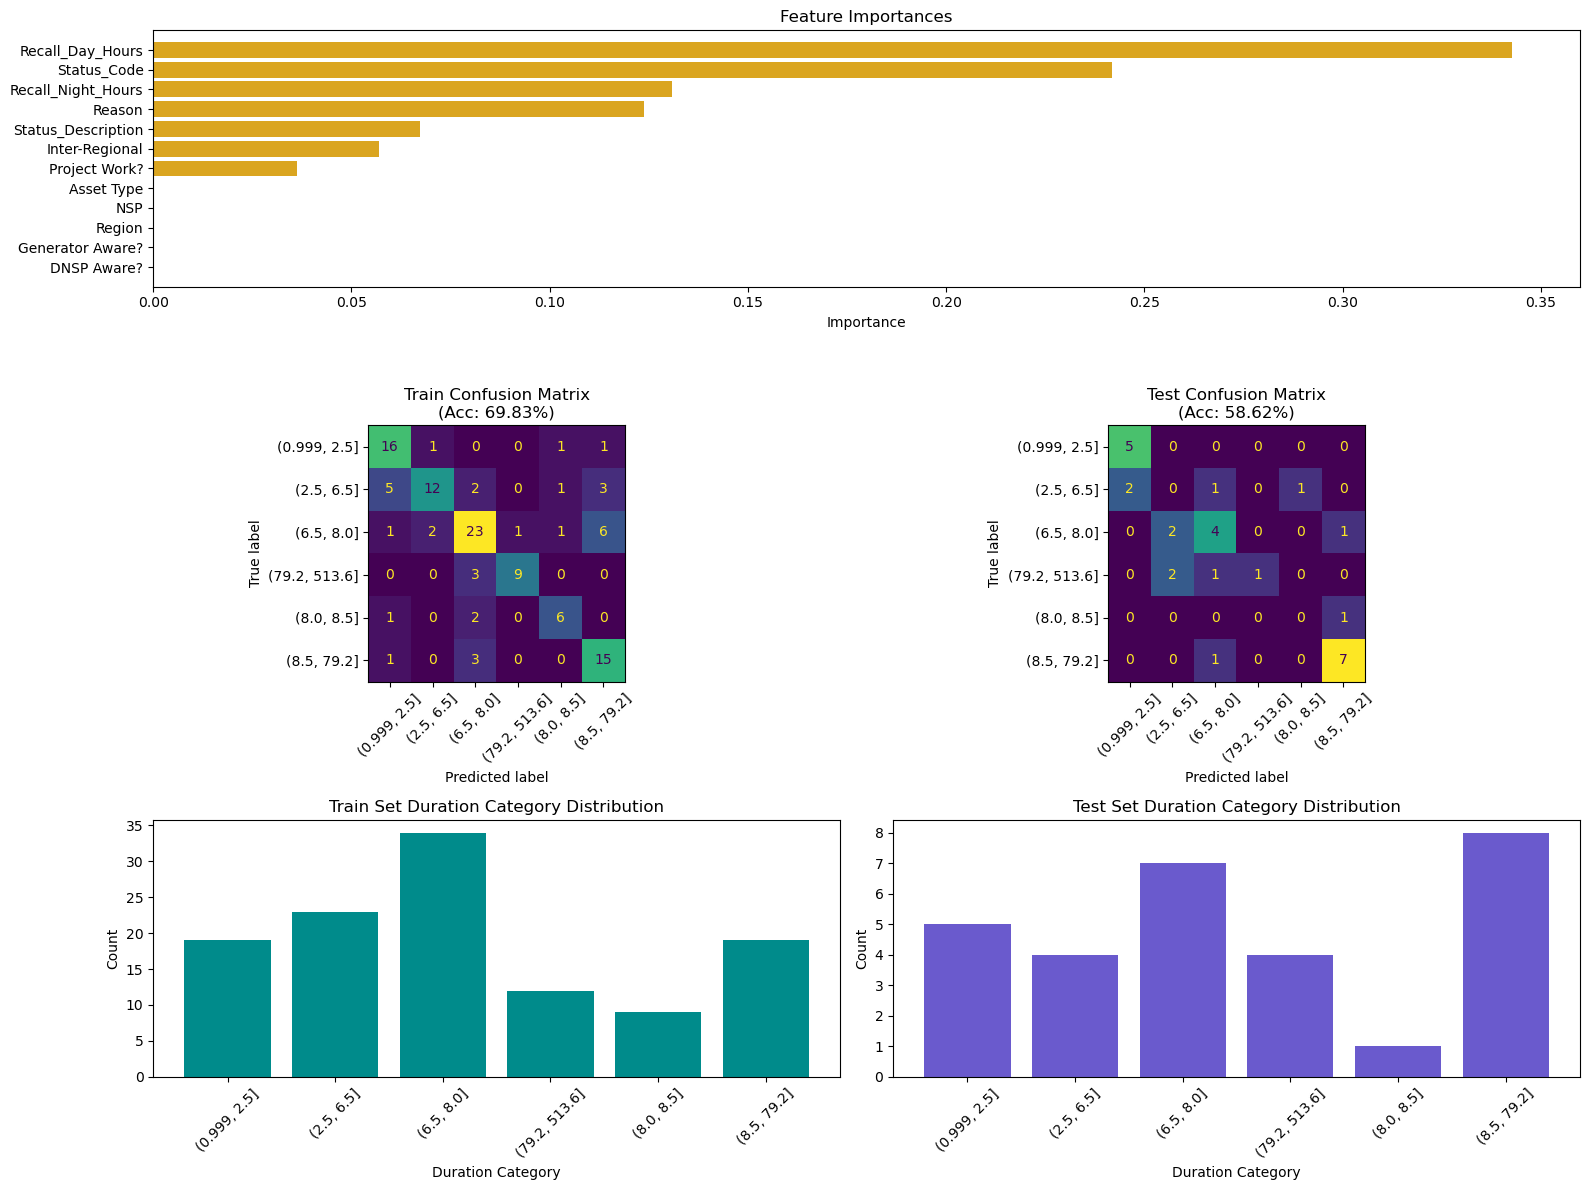

--- Region: QLD ---
Classification Report (Test Set):
                precision    recall  f1-score   support

 (0.169, 5.45]       0.73      0.80      0.76        10
(168.0, 921.6]       0.67      0.83      0.74        12
   (5.45, 9.0]       0.78      0.67      0.72        27
 (55.2, 168.0]       0.76      0.81      0.79        16
   (9.0, 55.2]       0.60      0.55      0.57        11

      accuracy                           0.72        76
     macro avg       0.71      0.73      0.72        76
  weighted avg       0.73      0.72      0.72        76



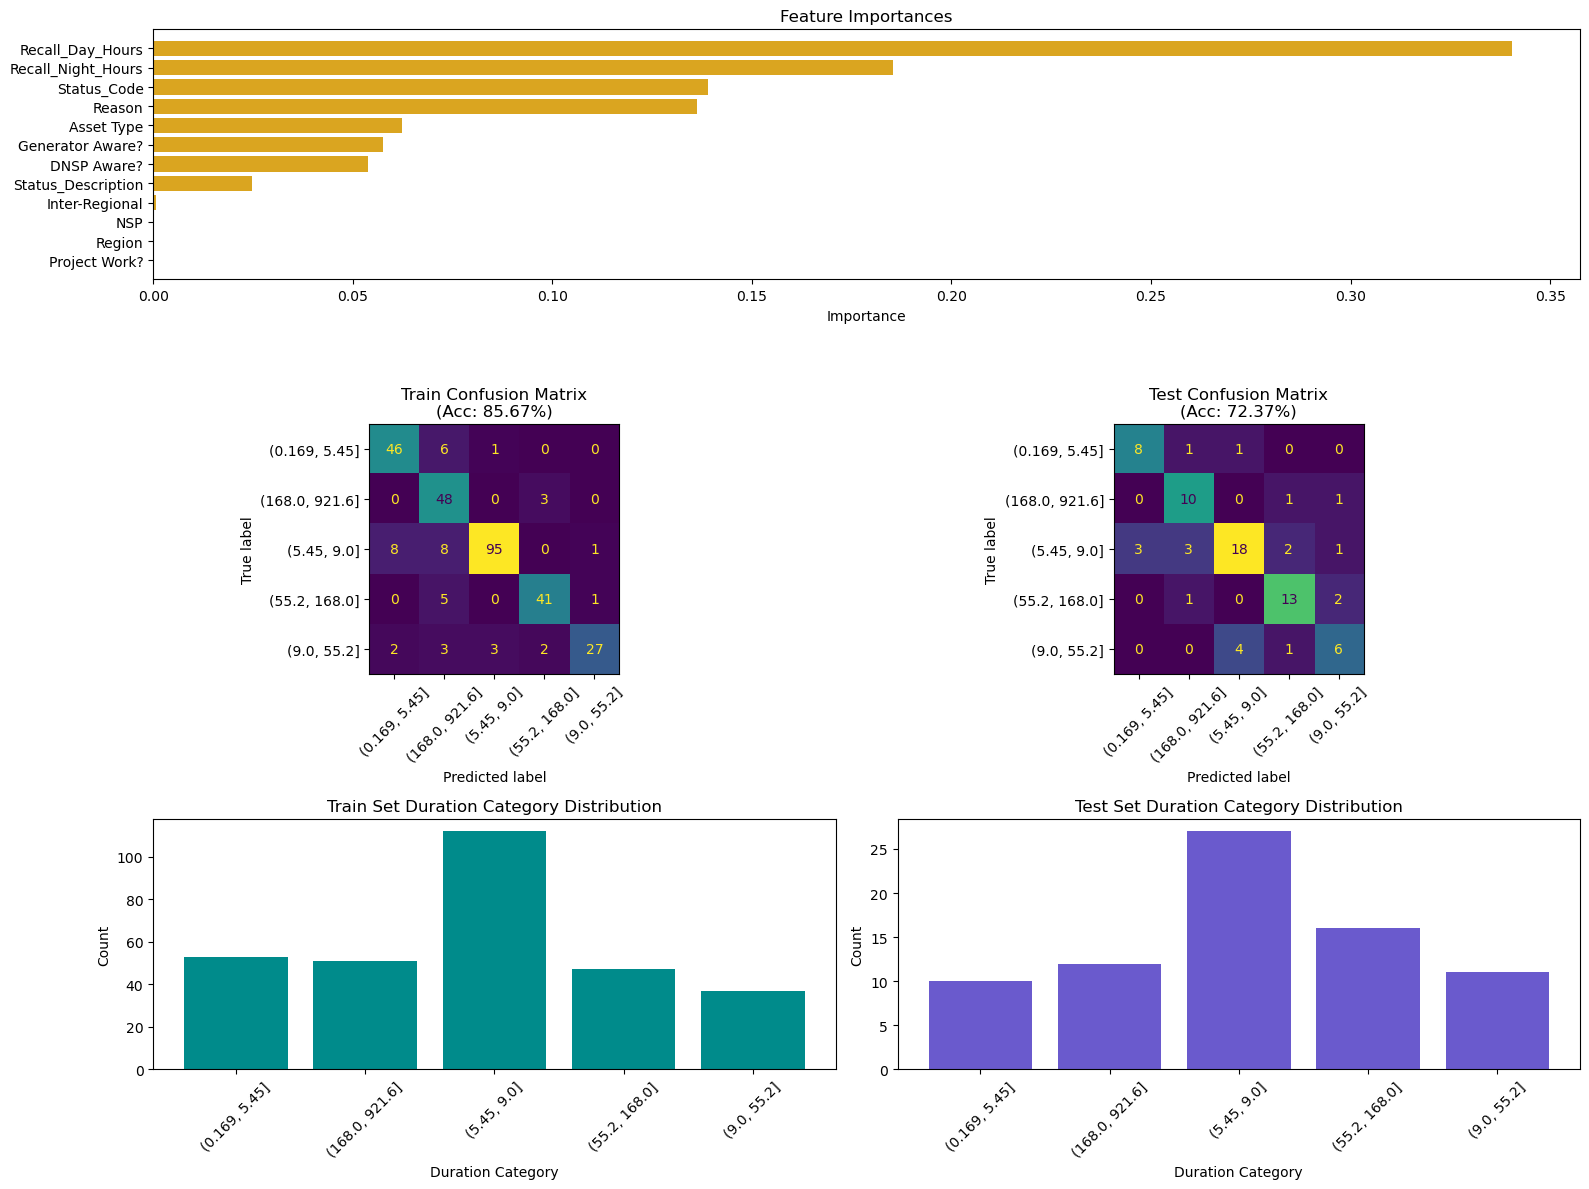

--- Region: NSW ---
Classification Report (Test Set):
               precision    recall  f1-score   support

(0.999, 10.0]       0.80      0.71      0.75        17
 (10.0, 12.0]       0.80      0.62      0.70        13
 (12.0, 14.0]       0.00      0.00      0.00         0
 (14.0, 78.0]       0.53      0.67      0.59        12
(78.0, 324.0]       0.90      0.69      0.78        13

     accuracy                           0.67        55
    macro avg       0.61      0.54      0.56        55
 weighted avg       0.77      0.67      0.71        55



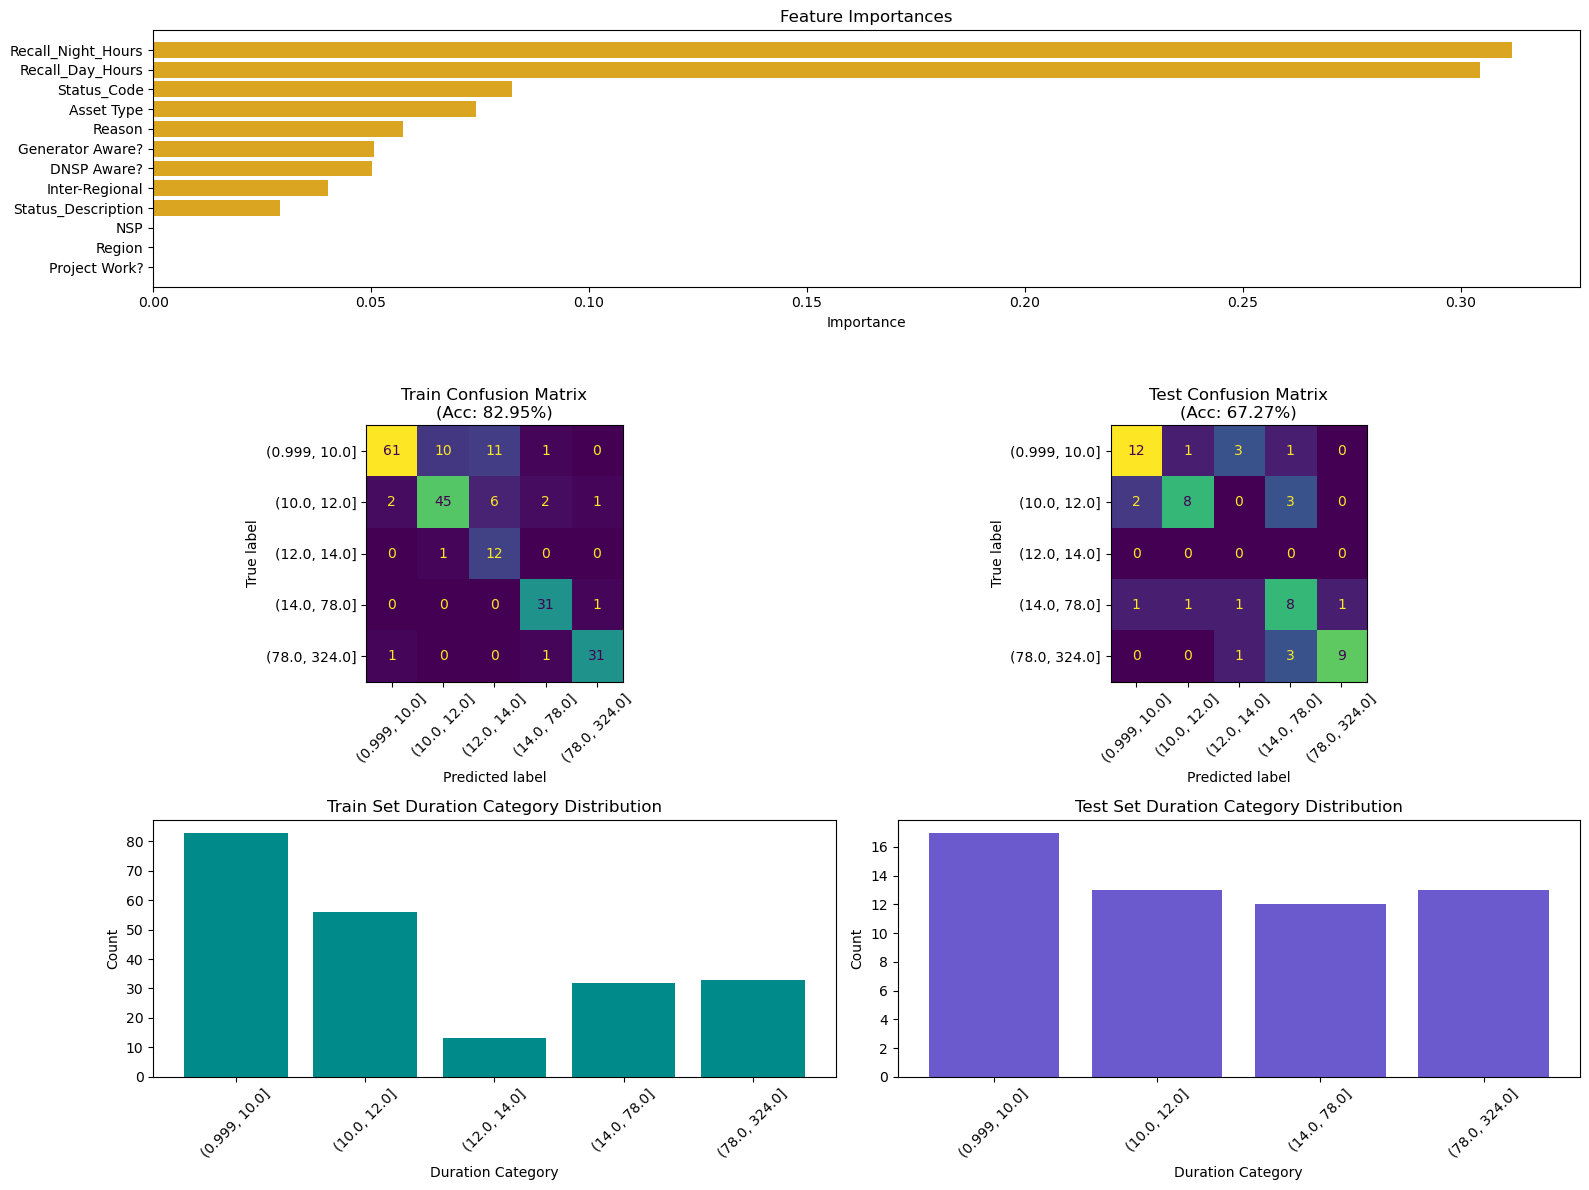

In [11]:
region_models = {}
for region in df['Region'].unique():
    print(f"--- Region: {region} ---")
    region_df = df[df['Region'] == region].copy()
    model = train_and_evaluate_rf(region_df)
    region_models[region] = model